In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import PIL

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.decomposition import PCA

In [2]:
IMG_H = 54
IMG_W = 44
to_tensor = transforms.ToTensor()
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean=mean, std=std)
resize = transforms.Resize((IMG_H, IMG_W))
trans = transforms.Compose([resize, to_tensor, normalize])

In [3]:
def tensor_to_img(tensor):
    """Undo Imagenet normalization and return a PIL image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    res = tensor * std + mean
    trans = transforms.ToPILImage()
    return trans(res)

In [5]:
def setup_data_loaders(batch_size=128, use_cuda=False):
    train = torchvision.datasets.ImageFolder("data/CelebA/train", transform=trans)
    test = torchvision.datasets.ImageFolder("data/CelebA/valid", transform=trans)
    train = Subset(train, list(range(len(train) // 20)))
    test = Subset(test, list(range(len(test) // 20)))
    print(len(train))
    print(len(test))

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [5]:
# Linear Decoder
class LinearDecoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc31 = nn.Linear(hidden_dim * 2, 3 * IMG_W * IMG_H)
        # self.upsample = nn.Upsample(size=(218, 178), mode="bilinear", align_corners=False)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.softplus(self.fc21(hidden))
        loc_img = self.sigmoid(self.fc31(loc_img))
        # loc_img = loc_img.view(-1, 3, 45, 55)
        # loc_img = self.upsample(loc_img)
        # print(loc_img.size())
        # loc_img = loc_img.view(-1, 3 * 218 * 178)
        return loc_img

In [6]:
# ConvTranspose
class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, 990)
        self.conv1 = nn.ConvTranspose2d(10, 10, 5, stride=5) # 10 x 55 x 45
        self.conv2 = nn.Conv2d(10, 3, 1) # 3 x 55 x 45
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        hidden = hidden.view(-1, 10, 11, 9)
        loc_img = self.relu(self.conv1(hidden))
        loc_img = self.sigmoid(self.conv2(loc_img))
        loc_img = loc_img[:, :, :IMG_H, :IMG_W]
        loc_img = loc_img.reshape(-1, 3 * IMG_W * IMG_H)
        return loc_img

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(32, 128, 3)
        self.pool2 = nn.AvgPool2d(2)
        self.conv3 = nn.Conv2d(128, 1000, 3)
        self.pool3 = nn.AdaptiveAvgPool2d(1)
        self.ReLU = nn.ReLU()
        self.fc21 = nn.Linear(1000, z_dim)
        self.fc22 = nn.Linear(1000, z_dim)

    def forward(self, x):
        x = self.ReLU(self.conv1(x))
        x = self.pool1(x)
        x = self.ReLU(self.conv2(x))
        x = self.pool2(x)
        x = self.ReLU(self.conv3(x))
        x = self.pool3(x)
        x = x.view(-1, 1000)
        z_loc = self.fc21(x)
        z_scale = torch.exp(self.fc22(x))
        return z_loc, z_scale

In [8]:
class VAE(nn.Module):
    def __init__(self, z_dim=200, use_cuda=False):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 3 * IMG_W * IMG_H))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        loc_img = loc_img.view(-1, 3, IMG_H, IMG_W)
        return loc_img

In [9]:
def train(svi, train_loader, use_cuda=False, scheduler=None):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
        if scheduler is not None:
            scheduler.step()

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [10]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.0
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [11]:
# Run options
LEARNING_RATE = 1e-3
USE_CUDA = True
NUM_PARTICLES = 1

NUM_EPOCHS = 250
TEST_FREQUENCY = 10

In [12]:
train_loader, val_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

8138
993


In [13]:
vae = VAE(z_dim=200, use_cuda=True)
vae = torch.load("models/vae2.pt")

In [13]:
# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(z_dim=200, hidden_dim=1000, use_cuda=True, freeze=False)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)
# optimizer = torch.optim.Adam
# scheduler = pyro.optim.OneCycleLR({'optimizer': optimizer, 'optim_args': adam_args, 
                                   # 'steps_per_epoch': len(train_loader), 'epochs' : NUM_EPOCHS, "max_lr": 1e-4})
# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=NUM_PARTICLES))
start_time = time.time()
train_elbo = []
test_elbo = []
best_test_loss = 0.0
# training loop
for epoch in range(1, NUM_EPOCHS + 1):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA, scheduler=None)
    train_elbo.append(-total_epoch_loss_train)
    if epoch % TEST_FREQUENCY != 0:
        continue
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    # report test diagnostics
    total_epoch_loss_test = evaluate(svi, val_loader, use_cuda=USE_CUDA)
    test_elbo.append(-total_epoch_loss_test)
    print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
    if total_epoch_loss_test < best_test_loss:
        best_test_loss = total_epoch_loss_test
        torch.save(vae, "models/vae1.pt")
    
print(f"Completed in {time.time() - start_time:.3f} seconds")

[epoch 001]  average training loss: -42312.6824
[epoch 001] average test loss: -56558.8512
[epoch 002]  average training loss: -60280.6379
[epoch 002] average test loss: -61951.0663
[epoch 003]  average training loss: -64650.0806
[epoch 003] average test loss: -65603.4594
[epoch 004]  average training loss: -67621.3994
[epoch 004] average test loss: -67610.9914
[epoch 005]  average training loss: -69114.1884
[epoch 005] average test loss: -68681.1703
[epoch 006]  average training loss: -70079.3414
[epoch 006] average test loss: -69587.9938
[epoch 007]  average training loss: -70843.0195
[epoch 007] average test loss: -70177.2714
[epoch 008]  average training loss: -71490.4891
[epoch 008] average test loss: -70860.5318
[epoch 009]  average training loss: -72056.5839
[epoch 009] average test loss: -71219.5067
[epoch 010]  average training loss: -72499.5632
[epoch 010] average test loss: -71808.3066
Completed in 1469.027 seconds


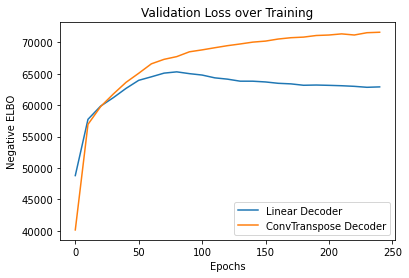

In [120]:
f, ax = plt.subplots()
arr1 = np.load("models/loss1.npy")
arr2 = np.load("models/loss2.npy")
x_vals = np.arange(0, 10 * len(arr1), 10)
ax.plot(x_vals, arr1)
ax.plot(x_vals, arr2)
ax.set_ylabel("Negative ELBO")
ax.set_xlabel("Epochs")
ax.set_title("Validation Loss over Training")
ax.legend(["Linear Decoder", "ConvTranspose Decoder"])
f.savefig("training.jpg")
plt.show()

In [19]:
def display_images(loader, st=0, num=5, save=False, name=""):
    for x, _ in loader:
        input = x[st:st + num, :, :, :]
        output = vae.reconstruct_img(x.cuda())
        output = output[st:st + num, :, :]
        break
    input_imgs = [tensor_to_img(x.cpu()) for x in input]
    output_imgs = [tensor_to_img(x.cpu()) for x in output]
    f, axes = plt.subplots(2, num, sharex=True, sharey=True)
    for x, imgs in enumerate([input_imgs, output_imgs]):
        for y, img in enumerate(imgs):
            axes[x, y].set_xticks([])
            axes[x, y].set_yticks([])
            axes[x, y].imshow(img)
            # axes[x, y].axis("off")
    if save:
        f.savefig(f"{name}{st}.jpg")

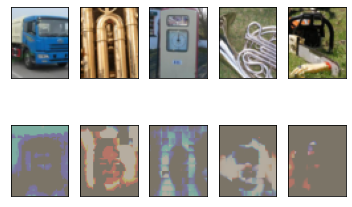

In [24]:
display_images(outlier_loader, st=5, name="outlier", save=True)

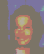

In [124]:
img1 = batch[3].view(1, 3, IMG_H, IMG_W)
r_img1 = vae.reconstruct_img(img1.cuda()).cpu().detach().view(3, IMG_H, IMG_W)
tensor_to_img(r_img1)

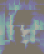

In [107]:
dummy = torch.rand((3, IMG_H, IMG_W))
dummy = normalize(dummy)
dummy = dummy.view(1, 3, IMG_H, IMG_W)
r_dummy = vae.reconstruct_img(dummy.cuda()).cpu().detach().view(3, IMG_H, IMG_W)
tensor_to_img(r_dummy)

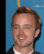

In [20]:
img1 = batch[3].view(1, 3, 54, 44)
img1 = tensor_to_img(img1.squeeze())
img1

In [16]:
c_crop = transforms.CenterCrop((IMG_H * 4, IMG_W * 4)) # Get image to right aspect ratio
img_nette = torchvision.datasets.ImageFolder(root="data/imagenette2-320/val", 
                                             transform=transforms.Compose([c_crop, resize, to_tensor, normalize]))
test_dataset = torchvision.datasets.ImageFolder("data/CelebA/test", transform=trans)

In [17]:
NUM_TOTAL = 1000
OUTLIER_RATIO = 0.05
NUM_OUTLIERS = int(NUM_TOTAL * OUTLIER_RATIO)

def get_subsets(inlier_ds, outlier_ds, seed=20200412):
    np.random.seed(seed)
    x1 = np.arange(len(inlier_ds))
    np.random.shuffle(x1)
    inliers = Subset(inlier_ds, x1[:NUM_TOTAL - NUM_OUTLIERS])
    
    np.random.seed(seed)
    x2 = np.arange(len(outlier_ds))
    np.random.shuffle(x2)
    outliers = Subset(outlier_ds, x2[:NUM_OUTLIERS])
    return inliers, outliers

inliers, outliers = get_subsets(test_dataset, img_nette)
kwargs = {'num_workers': 1, 'pin_memory': USE_CUDA}
inlier_loader = DataLoader(inliers, batch_size=64, shuffle=False, **kwargs)
outlier_loader = DataLoader(outliers, batch_size=64, shuffle=False, **kwargs)

In [18]:
def get_reconstruct_loss(loaders):
    losses = [list() for _ in loaders]
    with torch.no_grad():
        for idx, loader in enumerate(loaders):
            for x, _ in loader:
                x = x.cuda()
                res = vae.reconstruct_img(x)
                loss = torch.pow(x - res, 2)
                losses[idx].append(loss)
    losses = [torch.cat(x).cpu() for x in losses]
    return losses

def get_z_space(loaders):
    z_spaces = [list() for _ in loaders]
    with torch.no_grad():
        for idx, loader in enumerate(loaders):
            for x, _ in loader:
                x = x.cuda()
                z_loc, z_scale = vae.encoder(x)
                # sample in latent space
                z = dist.Normal(z_loc, z_scale).sample()
                z_spaces[idx].append(z)
    z_spaces = [torch.cat(z).cpu() for z in z_spaces]
    return z_spaces

def loader_to_numpy(loader):
    tensors = []
    for val, _ in loader:
        tensors.append(val)
    data = torch.cat(tensors)
    data = data.view(-1, 3 * 54 * 44)
    data = data.numpy()
    return data

def fit_pca(data, components, seed=20200412):
    pca = PCA(n_components=components, random_state=seed)
    pca.fit(data)
    return pca

In [24]:
pca_data = fit_pca(get_reconstruct_loss([val_loader])[0].view(-1, 3 * IMG_H * IMG_W))
res = get_reconstruct_loss([inlier_loader, outlier_loader])
res = [x.view(-1, 3 * IMG_H * IMG_W) for x in res]
res[0].size()

torch.Size([950, 7128])

In [25]:
res = [pca_data.transform(x) for x in res]

190000

In [87]:
with torch.no_grad():
    for original, _ in outlier_loader:
        original = original.cuda()
        res = vae.reconstruct_img(original)
        break

In [88]:
original = [tensor_to_img(x) for x in original.cpu()]
reconstructed = [tensor_to_img(x) for x in res.cpu()]

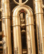

In [101]:
original[6]

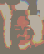

In [102]:
reconstructed[6]

In [26]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [30]:
def get_raw_data(components=200):
    torch.manual_seed(43)
    val_data = loader_to_numpy(val_loader)
    pca = fit_pca(val_data, components)
    inliers = loader_to_numpy(inlier_loader)
    outliers = loader_to_numpy(outlier_loader)
    data = np.zeros((NUM_TOTAL, components))
    data[:NUM_TOTAL - NUM_OUTLIERS, :] = pca.transform(inliers)
    data[NUM_TOTAL - NUM_OUTLIERS:, :] = pca.transform(outliers)
    return pca.transform(val_data), data

def get_latent_data():
    torch.manual_seed(43)
    val_data = get_z_space([val_loader])[0]
    zs = get_z_space([inlier_loader, outlier_loader])
    data = np.zeros((NUM_TOTAL, 200))
    data[:NUM_TOTAL - NUM_OUTLIERS, :] = zs[0]
    data[NUM_TOTAL - NUM_OUTLIERS:, :] = zs[1]
    return val_data, data

def get_reconstruct_data(components=200):
    torch.manual_seed(43)
    val_data = get_reconstruct_loss([val_loader])[0].view(-1, 3 * IMG_H * IMG_W)
    pca = fit_pca(val_data, components)
    inliers = get_reconstruct_loss([inlier_loader])[0].view(-1, 3 * IMG_H * IMG_W)
    outliers = get_reconstruct_loss([outlier_loader])[0].view(-1, 3 * IMG_H * IMG_W)
    data = np.zeros((NUM_TOTAL, components))
    data[:NUM_TOTAL - NUM_OUTLIERS, :] = pca.transform(inliers)
    data[NUM_TOTAL - NUM_OUTLIERS:, :] = pca.transform(outliers)
    return pca.transform(val_data), data

In [31]:
def unsupervised_detect(data, seed=20200412):
    #, contamination=OUTLIER_RATIO)
    methods = [
        IsolationForest(random_state=seed, n_jobs=1), 
        OneClassSVM(), 
        LocalOutlierFactor(novelty=False, n_jobs=1),
        EllipticEnvelope(random_state=seed),
        LocalOutlierFactor(novelty=False, contamination=OUTLIER_RATIO, n_jobs=1),
        EllipticEnvelope(random_state=seed, contamination=OUTLIER_RATIO)
    ]
    actual = np.ones(NUM_TOTAL)
    actual[-NUM_OUTLIERS:] = -1 # Last values are outliers
    reports = []
    for method in methods:
        predict = method.fit_predict(data)
        report = classification_report(actual, predict, output_dict=True, target_names=["outlier", "inlier"])
        reports.append(report)
    return reports
        
def semisupervised_detect(train, test, seed=20200412):
    methods = [
        LocalOutlierFactor(novelty=True),
        LocalOutlierFactor(novelty=True, contamination=OUTLIER_RATIO)  
    ]
    actual = np.ones(NUM_TOTAL)
    actual[-NUM_OUTLIERS:] = -1 # Last values are outliers
    reports = []
    for method in methods:
        method.fit(train)
        predict = method.predict(test)
        report = classification_report(actual, predict, output_dict=True, target_names=["outlier", "inlier"])
        reports.append(report)
    return reports

In [261]:
methods = ["IsolationForest", "OneClassSVM", "LOF", "EllipticEnvelope", 
           "LOF_Ratio", "Elliptic_Ratio", 
           "LOF_Novelty", "LOF_Novelty_Ratio"]

In [242]:
a, b = get_reconstruct_data()

In [243]:
c, d = get_reconstruct_data()

In [246]:
(a == c).all() and (b == d).all()

True

In [263]:
results = []
for fn in [get_raw_data, get_latent_data, get_reconstruct_data]:
    val, data = fn()
    results.append(unsupervised_detect(data) + semisupervised_detect(val, data))

In [95]:
import pandas as pd

In [264]:
res_arr = np.zeros((3, 8), dtype=np.float32)
for i, vals in enumerate(results):
    vals = [x["outlier"]["f1-score"] for x in vals]
    vals = np.array(vals)
    res_arr[i, :] = vals
res_arr

array([[0.25714287, 0.10181818, 0.        , 0.24      , 0.22      ,
        0.22      , 0.03921569, 0.19148937],
       [0.2       , 0.11956522, 0.13793103, 0.28      , 0.2       ,
        0.36      , 0.2       , 0.31578946],
       [0.43589744, 0.10889293, 0.27118644, 0.34666666, 0.36      ,
        0.42      , 0.33846155, 0.29032257]], dtype=float32)

In [267]:
pd.set_option("precision", 2)
res_df = pd.DataFrame(data=res_arr, index=["Original PCA", "Latent Data", "Reconstruction PCA"], 
                     columns=methods)
res_df.transpose()

,Original PCA,Latent Data,Reconstruction PCA
IsolationForest,0.26,0.20,0.44
OneClassSVM,0.10,0.12,0.11
LOF,0.00,0.14,0.27
EllipticEnvelope,0.24,0.28,0.35
LOF_Ratio,0.22,0.20,0.36
Elliptic_Ratio,0.22,0.36,0.42
LOF_Novelty,0.04,0.20,0.34
LOF_Novelty_Ratio,0.19,0.32,0.29


In [32]:
# Perform best performing method again, to analyze it in more detail
forest = IsolationForest(random_state=20200412)
_, forest_data = get_reconstruct_data()
actual = np.ones(NUM_TOTAL)
actual[-NUM_OUTLIERS:] = -1 # Last values are outliers
predict = forest.fit_predict(forest_data)

In [35]:
r = classification_report(actual, predict, output_dict=True, target_names=["outlier", "inlier"])
r["outlier"]

{'precision': 0.6071428571428571,
 'recall': 0.34,
 'f1-score': 0.43589743589743596,
 'support': 50}

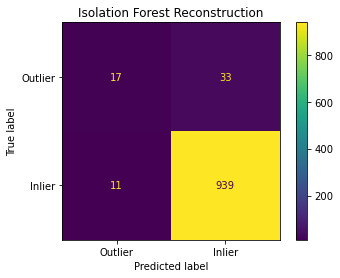

In [40]:
f, ax = plt.subplots()
conf_mat = confusion_matrix(actual, predict)
display = ConfusionMatrixDisplay(conf_mat, display_labels=["Outlier", "Inlier"])
display.plot(ax=ax)
ax.set_title("Isolation Forest Reconstruction")
f.savefig("conf_mat.jpg")